In [1]:
#importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import warnings
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import joblib

In [2]:
# Define the columns to keep
columns_to_keep = ["tsd", "Imp_Exp_flow", "settlement_date","renewable_generation", "england_wales_demand", "settlement_period", "is_holiday"]

# Load only the required columns
df_xg = pd.read_excel('/content/Cleaned_dataset.xlsx', usecols=columns_to_keep)

# Display the first few rows to confirm the structure
df_xg.head()

# Display the first few rows
df_xg.head()


,settlement_date,settlement_period,tsd,england_wales_demand,is_holiday,renewable_generation,Imp_Exp_flow
0,2009-01-01,1,38704.0,33939,1,54,1841
1,2009-01-01,2,38964.0,34072,1,53,1842
2,2009-01-01,3,38651.0,33615,1,53,1842
3,2009-01-01,4,37775.0,32526,1,50,1612
4,2009-01-01,5,37298.0,31877,1,50,1593


Splitting the Data

In [3]:
# Define the date thresholds for splitting
threshold_date_1 = "2021-06-01"  # Adjust based on your data
threshold_date_2 = "2023-06-01"  # Adjust based on your data

# Ensure 'settlement_date' is in datetime format
df_xg["settlement_date"] = pd.to_datetime(df_xg["settlement_date"])

# Split the data
train_data = df_xg.loc[df_xg["settlement_date"] < threshold_date_1]
test_data = df_xg.loc[(df_xg["settlement_date"] >= threshold_date_1) & (df_xg["settlement_date"] < threshold_date_2)]
hold_out_data = df_xg.loc[df_xg["settlement_date"] >= threshold_date_2]


In [4]:
# Display sizes of the splits for verification
print(f"Training set size: {train_data.shape[0]}")
print(f"Testing set size: {test_data.shape[0]}")
print(f"Hold-out set size: {hold_out_data.shape[0]}")

Training set size: 217606
Testing set size: 35036
Hold-out set size: 22558


Visualizing the Data Split

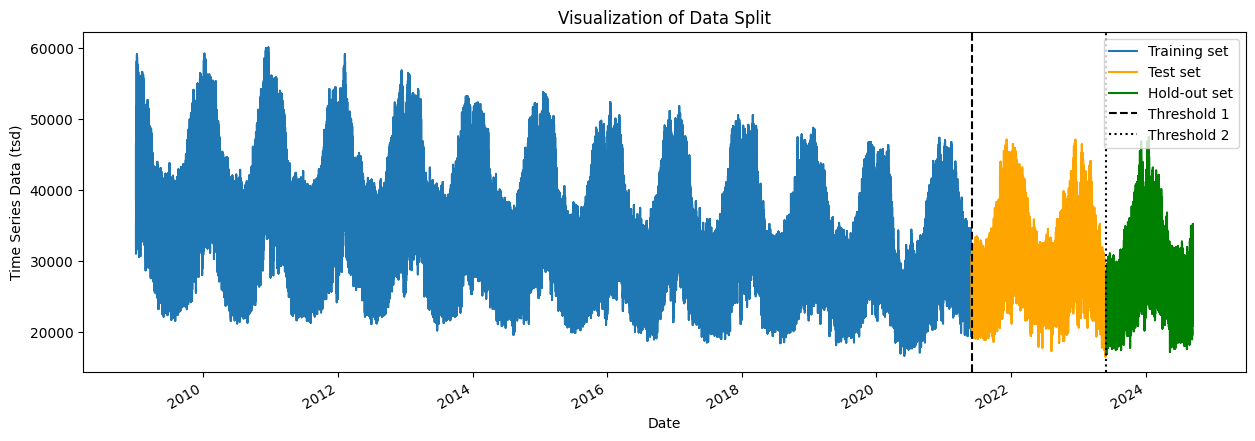

In [5]:
# Plot the splits
fig, ax = plt.subplots(figsize=(15, 5))

# Plot each dataset
train_data.plot(x="settlement_date", y="tsd", ax=ax, label="Training set")
test_data.plot(x="settlement_date", y="tsd", ax=ax, label="Test set", color="orange")
hold_out_data.plot(x="settlement_date", y="tsd", ax=ax, label="Hold-out set", color="green")

# Add vertical lines for threshold dates
ax.axvline(pd.to_datetime(threshold_date_1), color="k", linestyle="--", label="Threshold 1")
ax.axvline(pd.to_datetime(threshold_date_2), color="k", linestyle=":", label="Threshold 2")

# Title and legend
ax.set_title("Visualization of Data Split")
ax.set_xlabel("Date")
ax.set_ylabel("Time Series Data (tsd)")
ax.legend()

# Show plot
plt.show()


Features and Target Variable: Preparing Data for Model Training

In [6]:
# Convert settlement_date to numeric timestamp (seconds since epoch)
for df in [train_data, test_data, hold_out_data]:
    df["settlement_date_numeric"] = df["settlement_date"].astype(int) / 10**9  # Convert datetime to seconds

# Update features to use the numeric version of settlement_date
FEATURES = [
    "Imp_Exp_flow",
    "renewable_generation",
    "england_wales_demand",
    "settlement_date_numeric",
    "settlement_period", "is_holiday"
]
TARGET = "tsd"

# Prepare feature and target datasets
X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]
y_test = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES]
y_hold_out = hold_out_data[TARGET]

# Display shapes to confirm
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_hold_out shape: {X_hold_out.shape}, y_hold_out shape: {y_hold_out.shape}")

X_train shape: (217606, 6), y_train shape: (217606,)
X_test shape: (35036, 6), y_test shape: (35036,)
X_hold_out shape: (22558, 6), y_hold_out shape: (22558,)


<ipython-input-6-bb2879beb7ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["settlement_date_numeric"] = df["settlement_date"].astype(int) / 10**9  # Convert datetime to seconds
<ipython-input-6-bb2879beb7ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["settlement_date_numeric"] = df["settlement_date"].astype(int) / 10**9  # Convert datetime to seconds
<ipython-input-6-bb2879beb7ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Model Initialization and Training

In [7]:
# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,           # Number of trees
    max_depth=3,                # Maximum depth of each tree
    learning_rate=0.01,         # Step size shrinkage
    early_stopping_rounds=50,   # Stop training if validation error doesn't improve
    random_state=43             # For reproducibility
)

# Fit the model on the training data
xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],  # Evaluate on training and test data
    verbose=100                                       # Display training progress every 100 iterations
)


[0]	validation_0-rmse:7591.36543	validation_1-rmse:7125.06973
[100]	validation_0-rmse:2967.07071	validation_1-rmse:2664.34664
[200]	validation_0-rmse:1338.43350	validation_1-rmse:1507.27826
[294]	validation_0-rmse:810.38059	validation_1-rmse:1473.39819


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=43, ...)

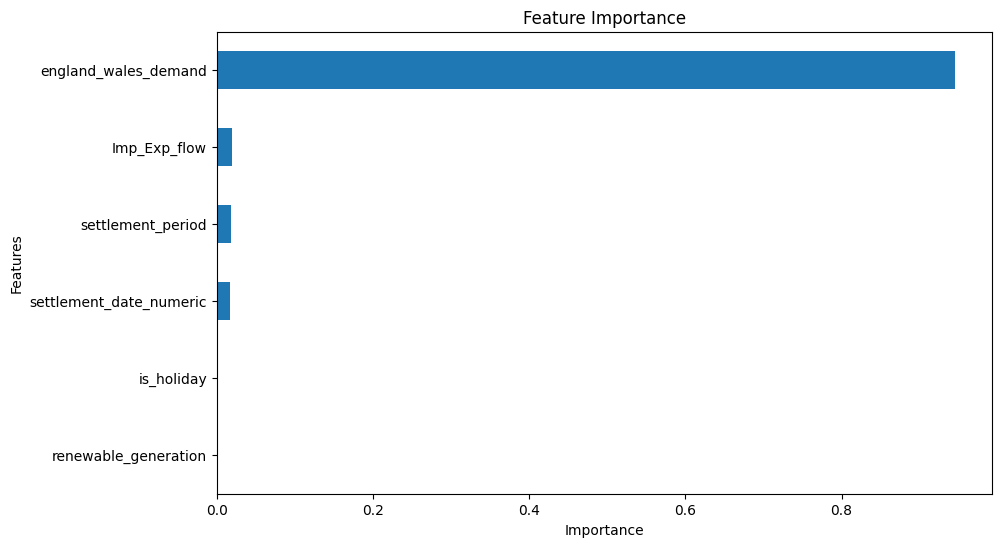

In [8]:

# Extract feature importance from the trained model
feature_importances = pd.DataFrame(
    data=xgb_model.feature_importances_,          # Feature importance values
    index=xgb_model.get_booster().feature_names,  # Feature names
    columns=["importance"]                        # Column name
)

# Sort the feature importance in ascending order
feature_importances.sort_values(by="importance", ascending=True, inplace=True)

# Plot the feature importance as a horizontal bar chart
feature_importances.plot(kind="barh", figsize=(10, 6), legend=False)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()


Predicting and Visualizing Test Results

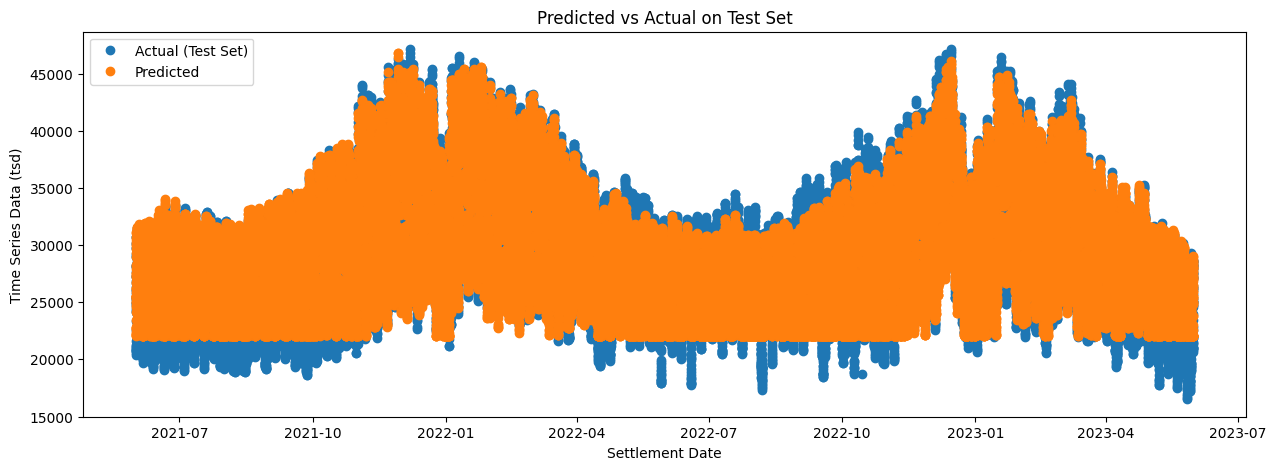

In [9]:
# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

# Create a DataFrame to compare actual and predicted values
result_frame = test_data.copy()
result_frame["Predicted_tsd"] = y_pred

# Plot the actual vs predicted values
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame["settlement_date"], result_frame["tsd"], "o", label="Actual (Test Set)")
ax.plot(result_frame["settlement_date"], result_frame["Predicted_tsd"], "o", label="Predicted")

# Add title and labels
ax.set_title("Predicted vs Actual on Test Set")
ax.set_xlabel("Settlement Date")
ax.set_ylabel("Time Series Data (tsd)")
ax.legend(loc="upper left")

# Show the plot
plt.show()


Code for Two-Week Focused Visualization

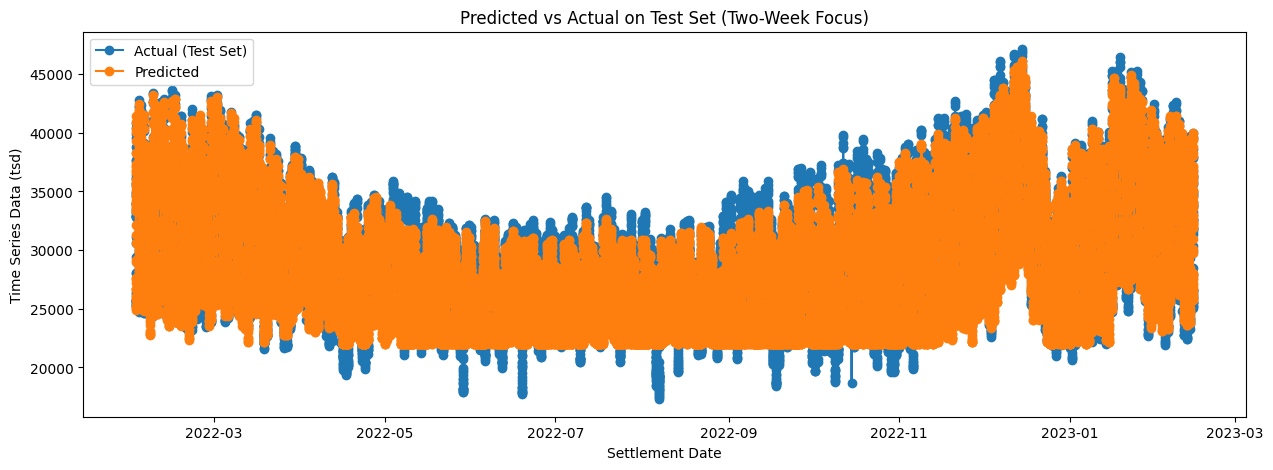

In [10]:
# Define the start and end dates for the two-week period
begin = "2022-02-01"
end = "2023-02-14"

# Filter the result_frame for the specified date range
two_week_frame = result_frame.loc[
    (result_frame["settlement_date"] >= begin) & (result_frame["settlement_date"] <= end)
]

# Plot the actual vs predicted values for the two-week period
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(two_week_frame["settlement_date"], two_week_frame["tsd"], "o-", label="Actual (Test Set)")
ax.plot(two_week_frame["settlement_date"], two_week_frame["Predicted_tsd"], "o-", label="Predicted")

# Add title and labels
ax.set_title("Predicted vs Actual on Test Set (Two-Week Focus)")
ax.set_xlabel("Settlement Date")
ax.set_ylabel("Time Series Data (tsd)")
ax.legend(loc="upper left")

# Show the plot
plt.show()


Calculating Error Metrics

In [11]:
# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print the results
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Percentage Error (MAPE): 4.09%
Root Mean Squared Error (RMSE): 1441.98


1. Cross Validation for Time Series

In [12]:
# Define time-series cross-validation split
n_years_test = 1
tss = TimeSeriesSplit(n_splits=4, test_size=48 * 365 * n_years_test, gap=48)  # Adjust for your dataset


2. Visualizing Cross-Validation Splits

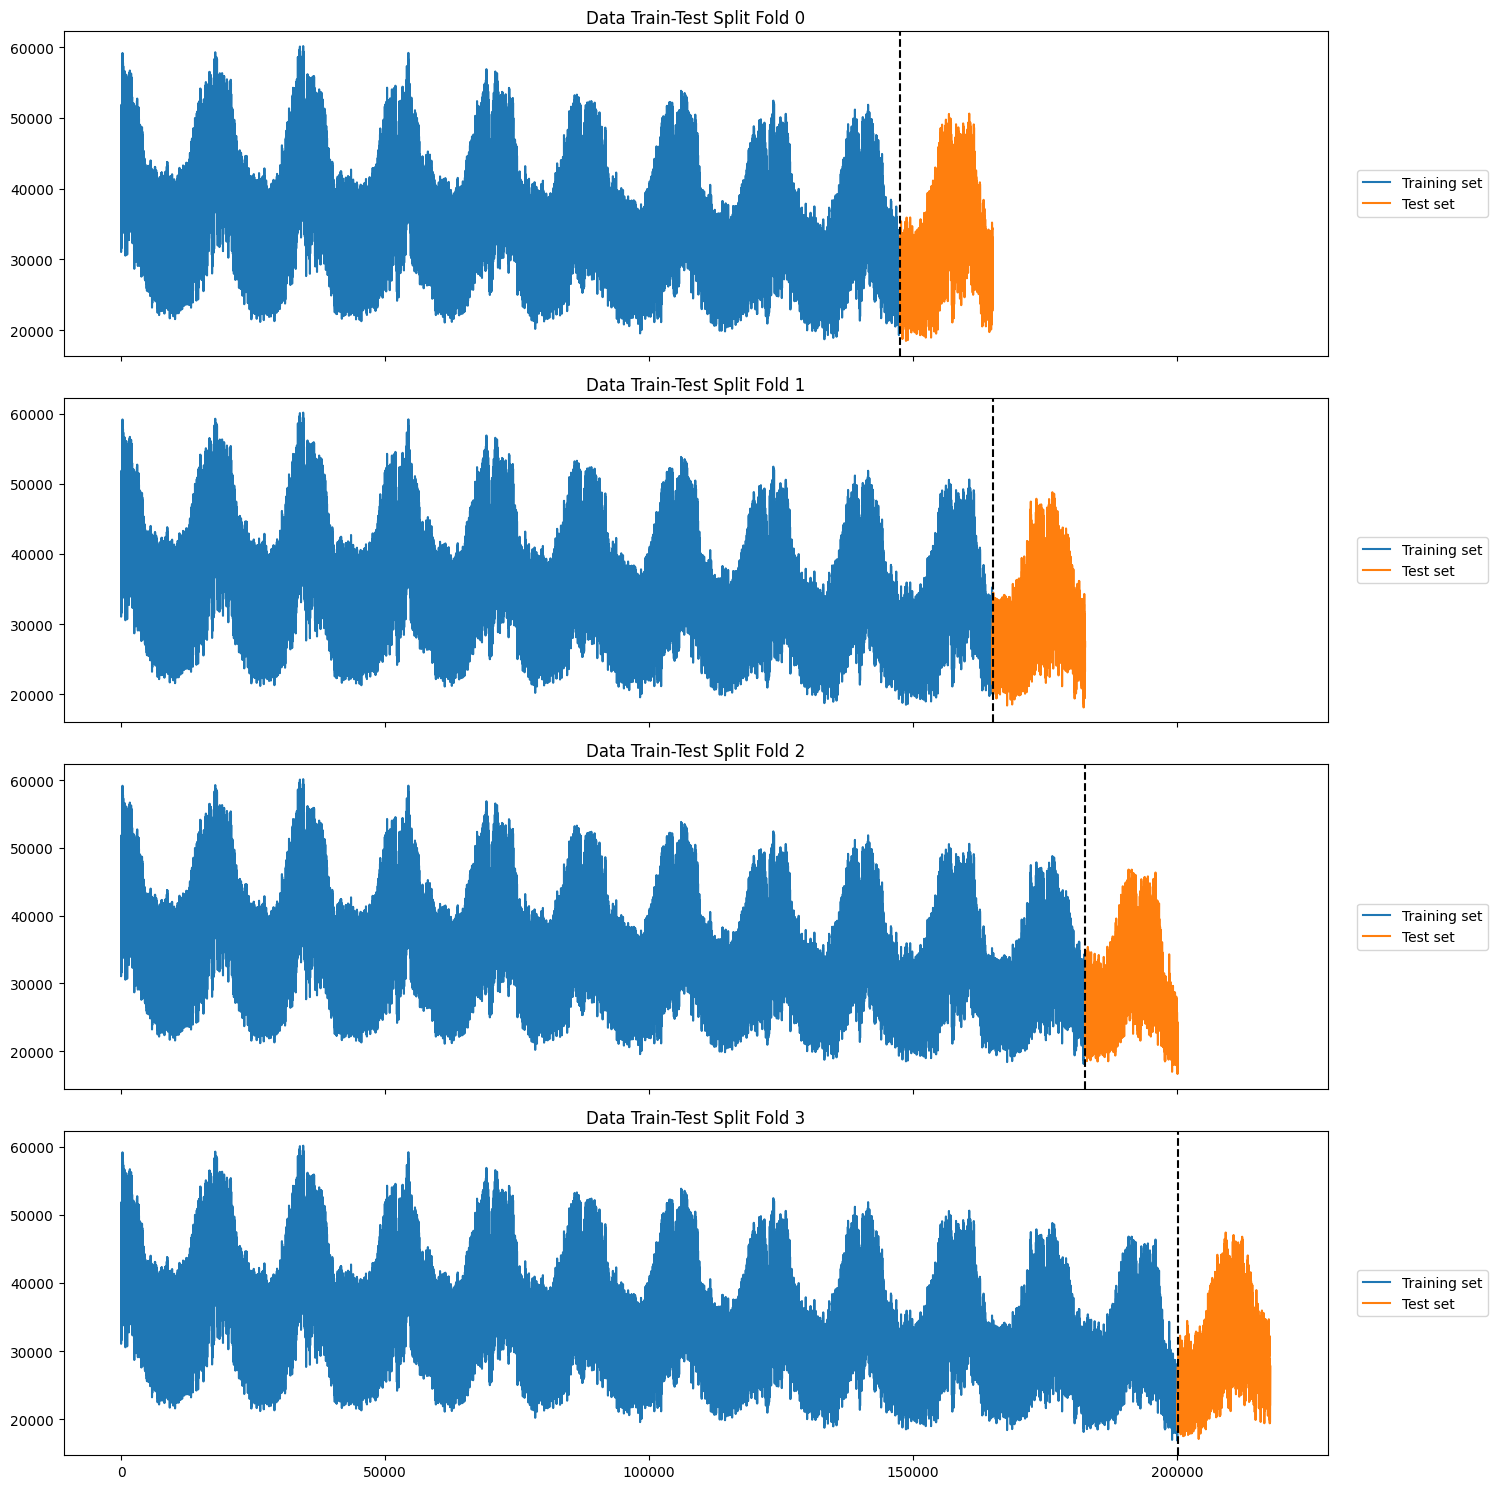

In [13]:
# Visualize the cross-validation splits
fig, axes = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_index, test_index in tss.split(train_data):
    train = train_data.iloc[train_index]
    test = train_data.iloc[test_index]

    train["tsd"].plot(ax=axes[fold], label="Training set", title=f"Data Train-Test Split Fold {fold}")
    test["tsd"].plot(ax=axes[fold], label="Test set")
    axes[fold].axvline(test.index.min(), color="k", ls="--")
    axes[fold].legend(loc="center", bbox_to_anchor=(1.075, 0.5))
    fold += 1

plt.tight_layout()
plt.show()


3. Ignoring Warnings

In [14]:
# Suppress non-critical warnings
warnings.filterwarnings("ignore")


4. Data Preparation for Cross-Validation

In [15]:
# Create lag features for train, test, and hold-out datasets
for df in [train_data, test_data, hold_out_data]:
    df["lag1"] = df["tsd"].shift(1)  # Lag by 1 time step
    df["lag2"] = df["tsd"].shift(2)  # Lag by 2 time steps
    df["lag3"] = df["tsd"].shift(3)  # Lag by 3 time steps

# Drop rows with NaN values caused by lagging
train_data = train_data.dropna()
test_data = test_data.dropna()
hold_out_data = hold_out_data.dropna()

In [16]:
# Define features and target for cross-validation
FEATURES_CV = [
    "Imp_Exp_flow",
    "renewable_generation",
    "england_wales_demand",
    "settlement_date_numeric",
    "settlement_period",
]
TARGET = "tsd"

# Prepare feature and target datasets for cross-validation
X_train_cv = train_data[FEATURES_CV]
y_train_cv = train_data[TARGET]

X_test_cv = test_data[FEATURES_CV]
y_test_cv = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES_CV]
y_hold_out = hold_out_data[TARGET]


5. Setting Up Model and Grid Search

In [17]:
# Define base model
model = xgb.XGBRegressor(
    learning_rate=0.01,
    tree_method="hist",  # Use "hist" for CPU training
    random_state=42,
)

# Define parameter grid
param_grid = {
    "max_depth": [3, 5],
    "n_estimators": [350, 500, 650],
    "subsample": [0.95, 0.8, 0.7],
}

# Set up GridSearchCV
xgb_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=tss,
    verbose=3,
)


6. Running Grid Search

In [18]:
# Fit GridSearchCV
xgb_search.fit(X_train_cv, y_train_cv)

# Print the best parameters and score
print(f"Best Parameters: {xgb_search.best_params_}")
print(f"Best Score: {-xgb_search.best_score_}")


Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-902.407 total time=   6.1s
[CV 2/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-893.906 total time=   1.9s
[CV 3/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-1003.053 total time=   4.4s
[CV 4/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-901.516 total time=   2.2s
[CV 1/4] END max_depth=3, n_estimators=350, subsample=0.8;, score=-901.576 total time=   1.8s
[CV 2/4] END max_depth=3, n_estimators=350, subsample=0.8;, score=-892.355 total time=   1.9s
[CV 3/4] END max_depth=3, n_estimators=350, subsample=0.8;, score=-1000.419 total time=   2.1s
[CV 4/4] END max_depth=3, n_estimators=350, subsample=0.8;, score=-898.893 total time=   4.5s
[CV 1/4] END max_depth=3, n_estimators=350, subsample=0.7;, score=-899.191 total time=   1.8s
[CV 2/4] END max_depth=3, n_estimators=350, subsample=0.7;, score=-891.479 total time= 

7. Predictions and Visualizations

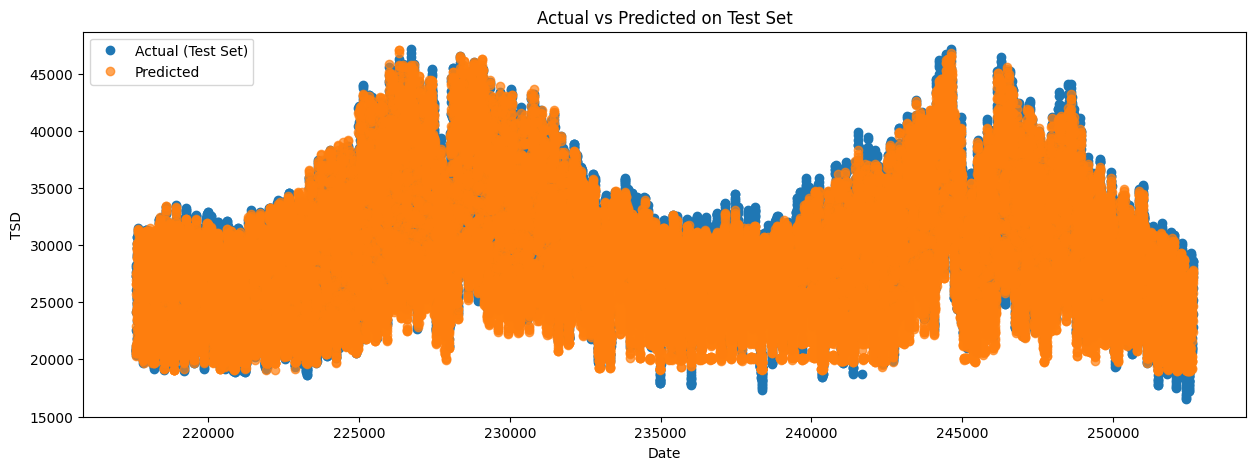

In [19]:
# Make predictions using the best model
result_frame = test_data.copy()
result_frame["Predicted_tsd"] = xgb_search.best_estimator_.predict(X_test_cv)

# Plot actual vs predicted values
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Actual (Test Set)")
ax.plot(result_frame.index, result_frame["Predicted_tsd"], "o", label="Predicted", alpha=0.7)
ax.legend(loc="upper left")
ax.set_title("Actual vs Predicted on Test Set")
ax.set_xlabel("Date")
ax.set_ylabel("TSD")
plt.show()


8. Error Metrics

In [20]:
# Calculate error metrics
mape = mean_absolute_percentage_error(y_test_cv, result_frame["Predicted_tsd"])
rmse = np.sqrt(mean_squared_error(y_test_cv, result_frame["Predicted_tsd"]))

# Print metrics
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Percentage Error (MAPE): 2.82%
Root Mean Squared Error (RMSE): 1091.40


In [21]:
# Save the best model from GridSearchCV
joblib.dump(xgb_search.best_estimator_, 'Correct_xgb.pkl')
print("Model saved as 'Correct_xgb.pkl'")


Model saved as 'Correct_xgb.pkl'
